# Database Analysis Code

Contains code to analyse the training set dataset used for the MPScore. This includes: identifying the functional groups present in the training database; an analysis of the consistency between chemists and the correlation between the SAScore, SCScore and chemist data.

In [63]:
from sqlalchemy import create_engine
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import json
from collections import defaultdict
from rdkit.Chem import AllChem as rdkit
import csv
from rdkit.Chem.MolStandardize import standardize_smiles
import seaborn as sns
from rdkit import Chem
pd.set_option("display.max_rows", None)

In [34]:
main_dir = Path.cwd().parent
con = create_engine(
    f"sqlite:///{str(Path.cwd().parents[0].joinpath('data/Molder_DB_SA_AddHs.db'))}"
)
df_training = pd.read_sql(sql='synthetic_accesibility', con=con)
molder_db_path = "/Users/stevenbennett/Box/Steven/Work/PhD/molder/database.json"
with open(molder_db_path, "r") as f:
    molder_db = json.load(f)

In [ ]:
# Analysing the functional groups in the training dataset
def find_functional_groups(db):
    fg_smarts = {
        'amine': ('[N]([H])[H]'),
        'aldehyde': ('[C](=[O])[H]'),
        'carboxylic_acid': ('[C](=[O])-[O][H]'),
        'fluorine': ('[F]'),
        'chlorine': ('[Cl]'),
        'bromine': ('[Br]'),
        'iodine': ('[I]'),
        'astatine': ('[As]'),
        'alcohol': ('[C]([H])([H])-[O][H]'),
        'alcohol2': ('[O][H]'),
        'alkene': ('[C]=[C]([H])[H]'),
        'alkyne': ('[C]#[C][H]'),
        'thiol': ('[S][H]'),
        'amide': ('[C](=[O])[N]([H])[H]'),
        'boronic_acid': ('[B]([O][H])[O][H]'),
        'xenon': ('[Xe]'),
        'methyl': ('[C]([H])([H])[H]'),
        'ethyl': ('[C]([H])([H])[C]([H])([H])[H]'),
        'propyl': ('[C]([H])([H])[C]([H])([H])[C]([H])([H])[H]'),
    }
    fg_counter = defaultdict(int)
    removed = []
    for inchi in tqdm(molder_db.keys()):
        mol = Chem.AddHs(Chem.MolFromInchi(inchi))
        for fg in fg_smarts:
            fg_smart = fg_smarts[fg]
            counter = 0
            substruct = Chem.MolFromSmarts(fg_smart)
            matches = mol.GetSubstructMatches(substruct)
            counter += len(matches)
            # Ignore molecules if functional groups are less than two.
            if counter >= 2:
                fg_counter[f'{fg}_{counter}'] += 1
                removed.append(inchi)
                break
    sorted_db_funcs = sorted(fg_counter.items(), key=lambda x: x[0])
    db_funcs = pd.DataFrame(sorted_db_funcs)
    return db_funcs
db_funcs = find_functional_groups(molder_db)
print(db_funcs)

In [61]:
# Analysing chemist data
def load_chemist_data():
    p1 = main_dir.joinpath("data/chemist_data/opinions_becky.json")
    p2 = main_dir.joinpath("data/chemist_data/opinions_mebriggs.json")
    p3 = main_dir.joinpath("data/chemist_data/filip.csv")
    # Finding disagreements in training data
    with open(str(p1)) as f:
        rg = json.load(f)
    with open(str(p2)) as f:
        mb = json.load(f)
    with open(str(p3)) as f:
        reader = csv.reader(f, delimiter='\t')
        fs = {rdkit.MolToInchi(rdkit.MolFromSmiles(smi)): sco for sco, smi in reader}
    def parse_training(training_dict):
        d = defaultdict(list)
        for inchi in training_dict:
            # Convert and standardise SMILES string.
            d['smiles'].append(standardize_smiles(rdkit.MolToSmiles(rdkit.MolFromInchi(inchi))))
            d['chemist_score'].append(int(training_dict[inchi]))
        return pd.DataFrame(d)
    fs = parse_training(fs)
    rg = parse_training(rg)
    mb = parse_training(mb)
    # Molecules scored by all three chemists
    all_three = rg.merge(fs, on='smiles').merge(mb, on='smiles')
    # Molecules scored by two chemists
    two = pd.concat([rg.merge(fs, on='smiles'), fs.merge(mb, on='smiles'), rg.merge(mb, on='smiles')])
    mols = [] 
    rows = []
    count = 0
    for i, r in all_three.iterrows():
        if (int(r.chemist_score_x) != int(r.chemist_score_y)) or (int(r.chemist_score_y) != int(r.chemist_score)):
            count+=1
            rows.append(r)
            mols.append(r.smiles)
    print(f"There were {len(all_three)} molecules labelled by all three chemists")
    print(f"{count} molecules were labelled the same by all three chemists and {len(all_three)-count} were labelled differently.")
    count = 0
    df1 = rg.merge(fs, on='smiles')
    df1[~df1['smiles'].isin(all_three['smiles'])]
    df2 = rg.merge(mb, on='smiles')
    df2[~df2['smiles'].isin(all_three['smiles'])]
    df3 = fs.merge(mb, on='smiles')
    df3[~df3['smiles'].isin(all_three['smiles'])]
    for r in pd.concat([df1, df2, df3]).itertuples():
        if (int(r.chemist_score_x) == int(r.chemist_score_y)):
            count+=1
    print(f'There were {count} molecules labelled the same out of those scored by two chemists.')
    print(f'There were {len(pd.concat([df1, df2, df3])) - count} molecules labelled differently out of those scored by two chemists.')
    print(f'RLG labelled {sum(rg.chemist_score)} easy-to-synthesise and {len(rg)-sum(rg.chemist_score)} difficult-to-synthesise')
    print(f'FS labelled {sum(fs.chemist_score)} easy-to-synthesise and {len(fs)-sum(fs.chemist_score)} difficult-to-synthesise')
    print(f'MB labelled {sum(mb.chemist_score)} easy-to-synthesise and {len(mb)-sum(mb.chemist_score)} difficult-to-synthesise')
load_chemist_data()

The correlation between the SAScore and SCScore is: 0.12156426384760034


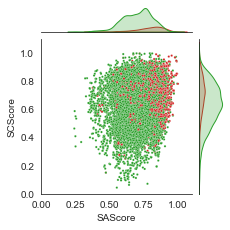

In [82]:
def plot_figure4():
    df_training = pd.read_csv(main_dir.joinpath('data/chemist_data/Training_Data_SA_Scores.csv'), names=['smiles', 'sas', 'scs', 'chemist_score', 'sas_norm', 'scs_norm'])
    # Scaling scores between 0 and 1
    df_training['sas_norm'] = [(val-10)/(1-10) for val in df_training['sas'].to_list()]
    df_training['scs_norm'] = [(val-5)/(1-5) for val in df_training['scs'].to_list()]
    # Plotting SA-SCScore correlations.
    print(f"The correlation between the SAScore and SCScore is: {df_training['scs'].corr(df_training['sas'])}")
    sns.set_style('white')
    palette = sns.color_palette()
    colors = [palette[2]] + [palette[3]]
    g = sns.jointplot(
        data=df_training,
        x='sas_norm',
        y='scs_norm',
        hue='chemist_score',
        palette=colors,
        space=0.3,
        xlim=[0,1.1],
        ylim=[0,1.1],
        s=5,
        linewidth=0.2,
        height= 3.3
    )
    g.set_axis_labels('SAScore', 'SCScore', fontsize='medium')
    g.ax_joint.legend_.remove()
    g.ax_joint.tick_params('both', labelsize='medium')
    return g
plot_figure4()

# POC Precursor Screening

In this section, we filter for easy-to-synthesise molecules using our developed MPScore, the SAScore and SCScore.
We show the distriubtions of synthetic difficulty scores for each precursor combination in our precursor database.

In [93]:
# Loading Reaxys data
import sys
sys.path.append(str(main_dir))
from scripts.mpscore import MPScore
con = create_engine(
    f"sqlite:///{str(main_dir.joinpath('data/Reaxys_DB_Scored_AddHs.db'))}"
)
df_reaxys = pd.read_sql(sql="synthetic_accesibility", con=con)
# Perform standardization on all molecules in Reaxys.
model = MPScore()
model.restore()
df_reaxys['standardized_smiles'] = [standardize_smiles(smi) for smi in df_reaxys['smiles']]
df_reaxys['rfmodel_fulldataset'] = [model.predict_proba(rdkit.AddHs(rdkit.MolFromSmiles(x))) for x in tqdm(df_reaxys['standardized_smiles'])]

/Users/stevenbennett/anaconda3/envs/saprojectclean/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/stevenbennett/anaconda3/envs/saprojectclean/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


  0%|          | 0/7288 [00:00<?, ?it/s]

In [86]:
def plot_figure6():
    sns.set_style('white')
    fig, ax = plt.subplots(1, figsize=(6.43420506434205/2, 3.1))
    sns.kdeplot(data=df_combinations, x='sascore_combination', ax=ax, color=palette[0])
    sns.kdeplot(data=df_combinations, x='scscore_combination', ax=ax, color=palette[1])
    sns.kdeplot(data=df_combinations, x='rfmodel_fulldataset_combination', ax=ax, color=palette[3])
    sns.despine()
    ax.set_xlabel('Synthetic Difficulty', fontsize='medium')
    ax.set_ylabel('Density', fontsize='medium')
    ax.axvline(df_combinations['sascore_combination'].quantile(0.01), 0, 0.7, color=palette[0], linestyle ="--")
    ax.text(df_combinations['sascore_combination'].quantile(0.01)+0.033, 3.7, f"{round(df_combinations['sascore_combination'].quantile(0.01), 2)}", color=palette[0], fontsize=8)
    ax.text(df_combinations['sascore_combination'].quantile(0.01)+0.03, 4, "SAScore", color=palette[0], fontsize=8)

    # ax.arrow(df_combinations['sascore_combination'].quantile(0.01), 4.45, -df_combinations['sascore_combination'].quantile(0.01), 0, color=palette[0], shape='full', head_width=0.25, head_length=0.03, length_includes_head=True)
    ax.axvline(df_combinations['scscore_combination'].quantile(0.01), 0, 0.7, color=palette[1], linestyle ="--")
    ax.text(df_combinations['scscore_combination'].quantile(0.01)-0.05, 3.7, f"{round(df_combinations['scscore_combination'].quantile(0.01), 2)}", color=palette[1], fontsize=8)
    ax.text(df_combinations['scscore_combination'].quantile(0.01)-0.07, 4, "SCScore", color=palette[1], fontsize=8)

    # ax.arrow(1, 4.75, -df_combinations['scscore_combination'].quantile(0.01), 0, color=palette[1], shape='full', head_width=0.25, head_length=0.03, length_includes_head=True)
    ax.axvline(df_combinations['rfmodel_fulldataset_combination'].quantile(0.01), 0, 0.7, color=palette[3], linestyle ="--")
    ax.text(df_combinations['rfmodel_fulldataset_combination'].quantile(0.01)-0.05, 3.7, f"{round(df_combinations['rfmodel_fulldataset_combination'].quantile(0.01), 2)}", color=palette[3], fontsize=8)
    ax.text(df_combinations['rfmodel_fulldataset_combination'].quantile(0.01)-0.11, 4, "MPScore", color=palette[3], fontsize=8)
    ax.tick_params(labelsize='medium')
    # ax.arrow(df_combinations['rfmodel_fulldataset_combination'].quantile(0.01), 4.15, -df_combinations['rfmodel_fulldataset_combination'].quantile(0.01), 0, color=palette[3], shape='full', head_width=0.25, head_length=0.03, length_includes_head=True)
    ax.set_xlim(0, 1.0)
    return fig, ax